# Insults  detection in Social Media

In this article, we consider the problem of detecting insults in social media comments. This is an important problem from a practical point of views since there are many social media sites such as youtube, yelp, etc, that are interested in detecting and filtering out comments that involve insults especially to other users. We use the data provided in [this](https://www.kaggle.com/c/detecting-insults-in-social-commentary) competition hosted by Kaggle. We follow the same setup and use the same performance criterion as in the competition to be able to compare our results to the winners of the competition.

## The Data and Problem Setup

At this competition, first "train.csv" was made available and contestants were ask to submit their preliminary models. Here is a random sample of the train data:

In [7]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
train = pd.read_csv("data/train.csv")
train.sample(5)

,Insult,Date,Comment
3223,0,20120619233439Z,"""@Lyoness....I was thinking the same thing how can you not know where your money is gonna...$2 millon is a lot of money hands down....I truly believe that k Michelle like others our using their pass and now relationship to get paid she's bitter that Memphiz is with Toya now....why didn't she say anything about all this last year???? When and Toya and Memphiz got married why she waited for a reality show!!!!! Please Help me out because I don't get it!!!!!"""
1226,0,20120619052850Z,"""courtt239 I'm a cat no shit your dog doesn't like me"""
2720,0,NaN,"""\\xc2\\xa0Freedom ain\\'t free... suck it up, quit whining, and make the effort to get the free ID...\\n\\nIf ""people will just not go through it"", then they don\\'t want to vote badly enough... We\\'re talking minimal standards here--kinda borderline pathetic!"""
69,0,20120527153941Z,"""you better hope because the Marlins have a history of giving up their superstars"""
3391,1,20120618194243Z,"""do you have any proof that Romney stole anything? Or are you just a stupid libtard troll?"""


The public and private leaderboad evaluation at this first stage was done on a test data set that later was made available as "test_with_solutions.csv". The contestants then submitted their final models which were evaluated on a verification set. This set was provided after the competition was disclosed as "impermium_verification_labels.csv".


In [2]:
test_with_solutions = pd.read_csv("data/test_with_solutions.csv")
verfication_set = pd.read_csv("data/impermium_verification_labels.csv")

Since we are interested in building the final model, we need to combine the "train" and "test_with_solutions" data sets and use that as training data:

In [3]:
train_total = pd.concat([train, test_with_solutions.iloc[:, :-1]]).reset_index()

After building our model we will evaluate the model performance on the "verification" data set above which serves as test data. Here is a glimpse of our training data:

In [19]:
train_total.sample(10)

,index,Insult,Date,Comment
1959,1959,1,20120529105937Z,"""You're analysis is exceptionally American. And by that I mean it's entirely grounded in fact-challenged star-spangled retardation- entirely voluntary in nature."""
2450,2450,0,20120530022806Z,"""Again:\xa0 I wouldn't count on it.\n\nAnyone who continues to support the current empty suit is either totally deluded or a_traitor."""
5844,1897,1,20120528034620Z,"""FANS ARE SOOOO BLIND DUMB. refs handed game to spurs??? THUNDER MADE two more free throws than the spurs (19 to 17) AND SPURS STILL WON! shut it haters"""
6376,2429,0,20120528043920Z,"""I don't know what to think about LW1 - it's possible that she's just not a facebook type person. Maybe she should change her settings so she doesn't get the updates and photos. That way she can look at their page if she feels like it but she won't be seeing more than she really wants to know. \n\nI have to agree though that writing about awesome presents you received or how much you really love, love, love your awesome BF, or telling everyone about your Valentines plans - seems a little like what CH called over sharing. I guess because it's not the kind of the info that I would think about announcing. For example, if my husband gives me an awesome gift - I don't rush to the phone to call everyone I know and tell them or even do a mass email to let everyone know. Same with plans for special occasions. \n\nIf someone asks me - then of course I'll tell them. But the announcing to the world thing does seem a little over the top when it comes to things like that. But then, that..."
4214,267,0,20120618211714Z,"""Fucking idiots. They should all be in jail. Make things worse for all of us responsible and respectful cyclists."""
3686,3686,0,20120530001221Z,"""What's he going to say? ""Nope sorry. Next question."". Then they would of criticized him for not answering a simple question. its lose-lose for him."""
4211,264,0,NaN,"""He had the potential but blew every one of his chances.\\n\\n \\n\\nNot good enough for Arsenal and he'll not be missed.\\n\\n \\n\\nI expect him to be at Spurs in 10 years or so."""
3483,3483,1,20120609175054Z,"""You really are NOTHING but an animal, aren't you?\n\nHave a nice day, I sincerely hope you manage to get some help for your anger issues.\n\nYou are OBVIOUSLY DEEPLY DISTURBED and you have my sympathy."""
3275,3275,0,20120609182832Z,"""I like politicians who wear their biases on their sleeves *much* better than the slick ones, who say only what the crowd before them wants to hear.\n\nLike *both* Presidential nominees this go round, and like Governor McDonnell of Virginia.\n\nMcDonnell has his vision set on higher office, and doesn't want to fuck it up right now."""
4589,642,0,20120530141243Z,"""One thing that disappointed me about DT last night... since my cable was out I was drawn to the threads and it was disgusting. People on here cussing at brooks, the refs, calling for whole sale changes.\n\xa0\nTo those where in the game thread last night. you should be ashamed. Knee-jerking and lambasting our team for every single thing that didn't go right. Seriously. I expected more from this group.\n\xa0\nyou want to complain? You want to give your advice? Then do that in a constructive manner. The time for debating whole sale changes and coaching extensions and amnestying Perk and what not will come later. But right now lets focus our energy on support OUR TEAM and looking at what they can do to improve.\n\xa0\nTHUNDER UP!"""


As we can see, we are provided with the text of the comments as well the date the comments were posted. Also the Insult column shows whether the comments is an insult. This is what we are required to predict for the test data.

We also see that the comments are not cleaned. For example the non-breaking spaces appear as "\xa0" and should be removed. Also there characters like "\n" and "\\n" which should be replaced by a white space.

## Text Cleaning

We construct a transformer which takes the comments as input and transforms them to cleaned comments:

In [4]:
import re
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        comments_clean = []
        for c in X:
            c = c.replace('\\\\', '\\')
            c = c.replace('\\n', ' ')
            c = re.sub(r'http[s]?://[^\s]*', ' ', c)
            c = re.sub(r'\\x[0-9a-f]{2}', ' ', c)
            c = re.sub(r'\\u[0-9a-f]{4}', ' ', c)
            c = re.sub(r'[-"]', '', c)
            c = re.sub(r'[:*#%&,.?!\']', ' ', c)
            c = re.sub(r"(.)\1{2,}", '\g<1>', c)
            #c = re.sub(r'@[^ ]*', ' ', c)
            #c = re.sub(r'[0-9]+', ' ', c)
            c = " ".join([wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(w, pos='v')).lower() 
                          for w in c.split()])

            #c = " ".join([w.lower() for w in c.split()])# if 3<=len(w)<=40])
            comments_clean.append(c)
        return comments_clean
    
preprocessor = Preprocessor()

The transformer above performs the following cleaning operations on the data:
* remove double-scape and carriage-return using ```c = c.replace('\\\\', '\\')``` and ```c = c.replace('\\n', ' ')``` 
* remove urls using ```c = re.sub(r'http[s]?://[^\s]*', ' ', c)```
* remove punctuation using ```c = re.sub(r'[:*#%&,.?!\']', ' ', c)```
* remove non-ascii and unicode characters using ```c = re.sub(r'\\x[0-9a-f]{2}', ' ', c)``` and ```c = re.sub(r'\\u[0-9a-f]{4}', ' ', c)```
* replace repeated characters with a single character so that e.g. word "heeelllll" will be converted to "hell"
* replace each word with its lemmatized version and convert all words to lower case
             
Here we can see the original and cleaned comments side-by-side.

In [38]:
train_sample = train_total.sample(10)
train_sample['Comment_clean'] = preprocessor.fit_transform(train_sample['Comment'])
train_sample[['Comment', 'Comment_clean']]

,Comment,Comment_clean
6378,"""I wear Gucci, I wear Prada, at the same damn time!""",i wear gucci i wear prada at the same damn time
6169,"""The D-Bags are absolutely atrocious from top to bottom - horrific pitching and zero offense.""",the dbags be absolutely atrocious from top to bottom horrific pitch and zero offense
6104,"""All of y'all sound like some lil bitches! Yeezy this ...Yeezy that...are they gonna...are they not gonna drop....man shut the fuck already. Every last one of y'all acting like some hypebeats. Pull your skirts down and your pants up and stop wettin yourself for a fuckin pair of shoes!""",all of y all sound like some lil bitch yeezy this yeezy that be they gonna be they not gonna drop man shut the fuck already every last one of y all act like some hypebeats pull your skirt down and your pant up and stop wettin yourself for a fuckin pair of shoe
6325,"""LOL...Why are you wasting your time reading the comments?""",lol why be you waste your time read the comment
432,"""@daredevil241\xa0\xa0@tomislavgrujic\xa0yea well when you do make sure you punch him with your right hand otherwise it might not be authentic enough for him""",@daredevil241 @tomislavgrujic yea well when you do make sure you punch him with your right hand otherwise it might not be authentic enough for him
4119,"""you are a mental midget you can't be\xa0 a traitor if you aren't a citizen.""",you be a mental midget you can t be a traitor if you aren t a citizen
2822,"""you're not stupid, just dumb""",you re not stupid just dumb
5952,"""GET YER TOWELS READY, ROENICK'S WARMING UP THE TEAR DUCTS""",get yer towels ready roenick s warming up the tear ducts
5224,"""He should be deported immediately, along with any others who would do us harm. And if the ECHR don't like it, tough. And when Britain really was Great, he would have been. But I am fully aware that our government haven't got what it takes to put the safety of the British people above kowtowing to Europe.""",he should be deport immediately along with any others who would do u harm and if the echr don t like it tough and when britain really be great he would have be but i be fully aware that our government haven t get what it take to put the safety of the british people above kowtow to europe
352,"""suck a dick pussy ass nigga bitch!!!""",suck a dick pussy as nigga bitch


## Feature Extraction

The most common way to extract feature from text is text vectorization. In this approach, first a bag-of-word representation of the documents is build which contains all the words that appear in any of the documents. Then the number of times each word appears in a document is calculated and is used as a feature vector to represent the document. Optionally, we can divide the word counts by the frequency of each word appearing in all the documents combine. This allows us to reduce the effect of very common words which do not convey much information. A detailed explanation of text vectorization techniques can be found [here](http://scikit-learn.org/stable/modules/feature_extraction.html).

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidv_char = TfidfVectorizer(ngram_range=(1, 2), analyzer='char', stop_words='english')
tfidv_word = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', stop_words='english')


In its plain form, text vectorization only considers word frequency and does not take into account the position of words relative to each other. In other words, it does not take into account the text "context". To alleviate this problem, as seen above, we can use the ngram_range parameter of the vectorizer. We also note that to extract richer set of features, we have used two vectorizers, one that works of words and one that works on characters.

In addition to standard features, we develop the following feature extractor transformer which extract features that are directly related to the problem of insult detection. This transformer extracts the following features:

* The count of bad words used the in comment.
* The number of positional tags such as verb, noun, adjective, etc, obtained using ntlk.
* The number of at mentions in the comment since we are asked to detect insults directed to other members as apposed to public figures like politicians or celebrities.

In [10]:
from nltk import word_tokenize
import nltk
from scipy import sparse

from sklearn.base import BaseEstimator
class FeatureExtractor(BaseEstimator):
    def __init__(self):
        with open('bad_words.txt') as f:
            self.badwords = set(w.strip() for w in f.readlines())
        
    def fit(self, X, y=None):
        self.fit_transform(X, y)
        return self

    def transform(self, X):
        return self.fit_transform(X)

    def fit_transform(self, X, y=None):

        pos_tags = ["VB", "JJ", "RB", "NN"]
        def pos_tag_count(comment):
            pos = nltk.pos_tag(word_tokenize(comment))
            d = {}
            for tag in pos_tags:
                d[tag] = 0
            for p in pos:
                for tag in pos_tags:
                    if p[1].startswith(tag):
                        d[tag] += 1
            return d.values()
    
        def bad_word_count(comment):
            cnt = 0
            for w in comment.split():
                if w.strip() in self.badwords:
                    cnt += 1
            return cnt
        
        def at_mention_count(comment):
            return len(re.findall(r'@[^\s]+', comment))
        
        comments_features = []
        for c in X:
            features = pos_tag_count(c)
            features.append(bad_word_count(c))
            features.append(at_mention_count(c))
            comments_features.append(features)
        
        return sparse.csr_matrix(comments_features)
                    

The next step is to combine the extracted features using FeatureUnion and create a pipeline which consists of preprocessing and cleaning, feature extraction, and classification.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion

tfidv_char = TfidfVectorizer(ngram_range=(1, 10), analyzer='char', stop_words='english', min_df=6)
tfidv_word = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', stop_words='english', min_df=2)
fe = FeatureExtractor()

fu = FeatureUnion([('fe', fe), ('tfidv_char', tfidv_char), ('tfidv_word', tfidv_word)])
#clf_rf = RandomForestClassifier()
clf_rf = LogisticRegression(C=3)

estimators = [('prep', preprocessor), ('fu', fu), ('clf', clf_rf)]
pl = Pipeline(estimators)

The metric used for the competition is ROC AUC score which can be calculated as follows.

In [12]:
from sklearn.metrics import roc_auc_score

def scoring(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    return roc_auc_score(y, y_pred[:, 1])

Using the scoring metric we can calculated the performance our pipeline using cross-validation:

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(pl, train_total.Comment, train_total.Insult, scoring=scoring)

array([ 0.89348157,  0.89643174,  0.90271682])

The validation score looks great and have small variations across the cross-validation folds. But we should keep in mind that this is out local validation score and does not necessarily translate directly to leader-board score. Nevertheless, we can use the local score as a proxy for the leader board score and employ it to improve the classification performance. 

In the following we use grid-search to perform an exhaustive search over a range of parameters for feature extraction and classification steps in out data pipeline. 

In [67]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'clf__C':np.logspace(-1, 2, 5),
              'fu__tfidv_word__ngram_range': [(1, 1), (1, 2)],
              'fu__tfidv_char__ngram_range': [(1, 1), (1, 3)],
              'fu__tfidv_char__min_df': [1, 2, 4],
              'fu__tfidv_char__stop_words': ['english', None],
             }
gs = GridSearchCV(pl, param_grid, scoring=scoring, n_jobs=2)
gs.fit(train_total.Comment, train_total.Insult)

gs.best_params_

{'clf__C': 3.1622776601683795,
 'fu__tfidv_char__min_df': 4,
 'fu__tfidv_char__ngram_range': (1, 3),
 'fu__tfidv_char__stop_words': 'english',
 'fu__tfidv_word__ngram_range': (1, 2)}

In [69]:
gs.best_score_

0.9057639823535467

The fact that we obtain the highest score for the largest values of n_gram parameters suggests that we may be able to gain by increasing this parameter. To explore this we perform the following optimization:

In [128]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'clf__C':np.logspace(0, 1.5, 10),
              'fu__tfidv_word__ngram_range': [(1, 3)],
              'fu__tfidv_char__ngram_range': [(1, 3), (1, 5), (1, 7), (1, 9)],
              'fu__tfidv_char__min_df': [4],
              'fu__tfidv_char__stop_words': ['english'],
             }
gs = GridSearchCV(pl, param_grid, scoring=scoring, n_jobs=4, verbose=10)
gs.fit(train_total.Comment, train_total.Insult)

gs.best_score_

0.90810569784332618

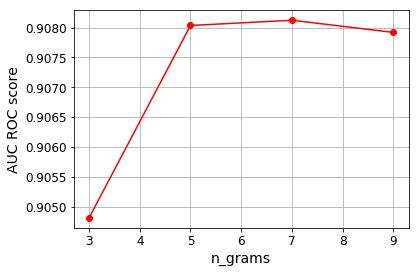

In [124]:
import matplotlib.pyplot as plt
x_data = [3, 5, 7, 9]
y_data = gs.cv_results_['mean_test_score'].reshape(10, 4).max(axis=0)
plt. plot(x_data, y_data, 'r-o');
plt.xlabel('n_grams', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('AUC ROC score', fontsize=14)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


## Test Set Validation

We take the model obained using the above optimization as our final model. The next step is to evaluate our model on the test set provided for the competition (called verification set "impermium_verification_labels.csv").

In [138]:
from sklearn.metrics import roc_auc_score

clf = gs.best_estimator_

clf.fit(train_total.Comment, train_total.Insult)
y_ver_pred = clf.predict_proba(verfication_set.Comment)[:, 1]
y_ver = verfication_set.Insult

roc_auc_score(y_ver, y_ver_pred)


0.8191599995509821

Out final score is considerably lower than the local validation score of 0.9081. But if turn to the private leaderboard of the competition, we find that the best score was [0.84248](https://www.kaggle.com/c/detecting-insults-in-social-commentary/leaderboard). This means that we have achieved more than 97% of the winning solution score which is great specially considering that we used logistic regression which is not considered a complex classifier. On the plus side however, logistic regression is very fast and efficient which is advantagous when using the model on real world data to classify comments as they are received.